In [139]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [140]:
import matplotlib
import seaborn
rcParams['figure.figsize'] = (16, 4)

In [141]:
from IPython.display import Audio

In [142]:
from __future__ import with_statement, print_function, absolute_import

import sys
from os.path import join, expanduser, splitext
from os import listdir
import scipy.io.wavfile
from tqdm import tqdm
import math
from tqdm import tnrange, tqdm_notebook

In [143]:
import pyworld
import librosa
import librosa.display
import numpy as np

## Analysis settings

In [144]:
fs = 16000
frame_period_msec = 5
frame_period = frame_period_msec * 0.001
hop_length = int(frame_period * fs)

## CMU arctic data

In [145]:
DATA_ROOT = join(expanduser("~"), "data", "cmu_arctic")

speaker_list = [
    "cmu_us_awb_arctic",
    "cmu_us_bdl_arctic",
    "cmu_us_clb_arctic",
    "cmu_us_jmk_arctic",
    "cmu_us_ksp_arctic",
    "cmu_us_rms_arctic",
    "cmu_us_slt_arctic",
    ]

speaker_identifiers = [
    ("awb", 0),
    ("bdl",1),
    ("clb", 2),
    ("jmk",3),
    ("ksp",4),
    ("rms", 5),
    ("slt", 6),
]

n_speakers = len(speaker_identifiers)

speaker_dirs = list(map(lambda x : join(DATA_ROOT, x, "wav"), speaker_list))

cmu_arctic_all_paths = {}
for (i, s) in enumerate(speaker_dirs):
    files = [join(speaker_dirs[i], f) for f in listdir(s)]
    files = list(filter(lambda x : splitext(x)[1] == ".wav", files))
    s, _ = speaker_identifiers[i]
    cmu_arctic_all_paths[s] = files

## Prepare joint data that contains speaker features with one-hot speaker vector

In [146]:
n_speakers = 3
assert n_speakers <= len(speaker_identifiers)

X = None
Y = None
limit_ulterances = None
limit_duration_min_per_speaker = 30
enable_trim = True

# TODO: rearange_idx

# for each speaker
for (identifier, n) in speaker_identifiers[:n_speakers]:
    total_seconds = 0
    speaker_paths = cmu_arctic_all_paths[identifier]
    print("Collecting speaker features for {}".format(identifier))
    
    for (i, f) in enumerate(tqdm_notebook(speaker_paths[:limit_ulterances])):
        # Read audio file and then process it with WORLD
        fs, x = scipy.io.wavfile.read(f)
        total_seconds += len(x) / fs
        x = x.astype(np.float64)
        if enable_trim:
            x, _ = librosa.effects.trim(x, top_db=50, frame_length=1024, hop_length=hop_length)
        f0, sp, ap = pyworld.wav2world(x, fs, frame_period = frame_period_msec)
        
        # log spectrum as a feature vector
        fv = np.log(sp).astype(np.float32)
        if X is None:
            X = fv
        else:
            X = np.vstack((X, fv))
                
        # One-hot
        onehot = (np.arange(n_speakers) == n).astype(np.float32)
        # For convenience, repeat for every frame
        y = np.array([onehot] * fv.shape[0])
        if Y is None:
            Y = y
        else:
            Y = np.vstack((Y, y))
        
        if limit_duration_min_per_speaker is not None and total_seconds > 60 * limit_duration_min_per_speaker:
            print("Collected duration ({} mins) exceeds limit length, break".format(total_seconds/60))
            break

print(X.shape)
assert Y.shape[0] == X.shape[0]
assert X.dtype == np.float32


Collected duration (30.033333333333335 mins) exceeds limit length, break

Collected duration (30.015854166666657 mins) exceeds limit length, break

Collected duration (30.02616666666664 mins) exceeds limit length, break
(1038874, 513)


In [147]:
import librosa
import librosa.display

understand_its_heaby = False
if understand_its_heaby:
    librosa.display.specshow(X.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
    colorbar()
    title("Spectral envelope estimate from mel-cepstrum")

## How data look like? Take a random example

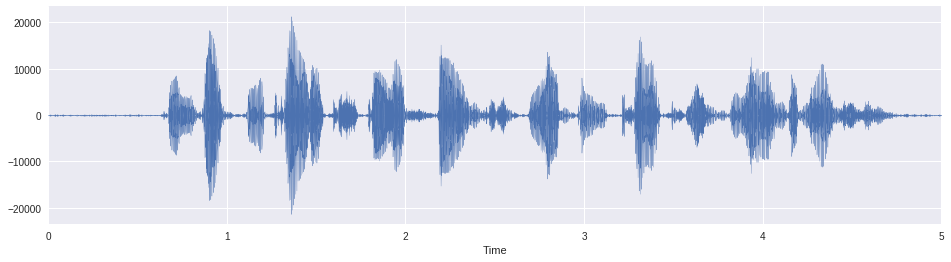

In [148]:
idx = int(np.random.randint(0, len(cmu_arctic_all_paths["awb"]), size=1))
fs, x = scipy.io.wavfile.read(cmu_arctic_all_paths["awb"][idx])
x = x.astype(np.float64)
librosa.display.waveplot(x, sr=fs)
Audio(x, rate=fs)

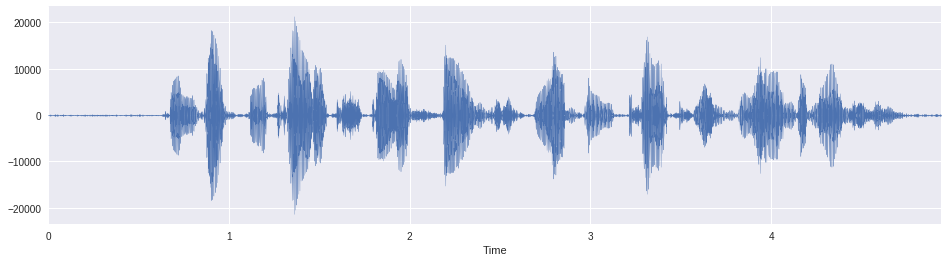

In [149]:
yt, idx = librosa.effects.trim(x, top_db=50, frame_length=1024, hop_length=80)
x = yt
librosa.display.waveplot(x, sr=fs)
Audio(x, rate=fs)

In [150]:
f0, sp, ap = pyworld.wav2world(x, fs, frame_period = frame_period_msec)

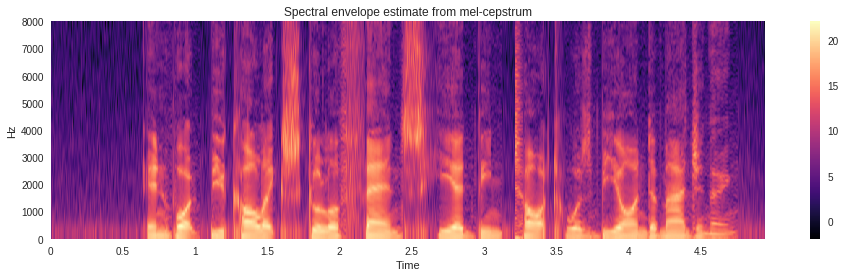

In [151]:
librosa.display.specshow(np.log(sp).T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-cepstrum")

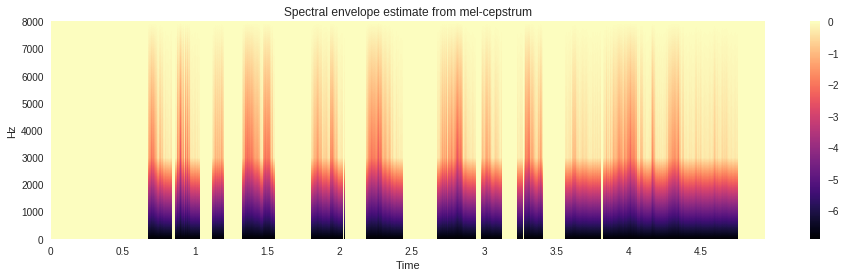

In [152]:
librosa.display.specshow(np.log(ap).T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-cepstrum")

## Preprocess

In [153]:
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [154]:
ss = StandardScaler()
ss.fit(X)
X_normalized = ss.fit_transform(X)

In [155]:
Y.shape

(1038874, 3)

## Train and test split

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(831099, 513)
(831099, 3)
(207775, 513)
(207775, 3)


## Train

In [157]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

In [166]:
n_in = X_train.shape[1]
n_labels = Y_train.shape[1]
n_latent = 64
cuda = True

## Conditional VAE

In [167]:
class CVAE(nn.Module):
    def __init__(self, n_in, n_latent, n_labels, use_label_in_encode=False):
        super(CVAE, self).__init__()
        if use_label_in_encode:
            n_encode_in = n_in + n_labels
        else:
            n_encode_in = n_in
        self.fc1 = nn.Linear(n_encode_in, 500)
        self.fc21 = nn.Linear(500, n_latent)
        self.fc22 = nn.Linear(500, n_latent)
        self.fc3 = nn.Linear(n_latent+n_labels, 500)
        self.fc4 = nn.Linear(500, n_in)
        self.relu = nn.ReLU()
        
        self.use_label_in_encode = use_label_in_encode
        self.n_in = n_in
        self.n_labels = n_labels

    def encode(self, x, y):
        if self.use_label_in_encode:
            data = torch.cat((x, y), -1)
        else:
            data = x
        h1 = self.relu(self.fc1(data))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z, y):
        h3 = self.relu(self.fc3(torch.cat((z, y.view(-1, self.n_labels)), -1)))
        return self.fc4(h3)

    def forward(self, x, y):
        mu, logvar = self.encode(x.view(-1, self.n_in), y.view(-1, self.n_labels))
        z = self.reparametrize(mu, logvar)
        return self.decode(z, y), mu, logvar

In [168]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n_in, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, n_latent)
        self.fc32 = nn.Linear(512, n_latent)
        self.fc4 = nn.Linear(n_latent,512)
        self.fc5 = nn.Linear(512, 512)
        self.fc6 = nn.Linear(512, n_in)

        self.relu = nn.ReLU()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.fc6(h5)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, n_in))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

## Loss

Gaussian observation model X ~ N(f(z;θ), σI)

In [169]:
def gaussian_nll(x, mean, logsigma2):
    sigma2 = torch.exp(logsigma2) # sigma^2
    x_diff = x - mean
    x_power = x_diff * x_diff / sigma2 * -0.5
    return (logsigma2 + math.log(2 * math.pi)) * 0.5 - x_power

# Hyper parameter for observation model
sigma2 = 1.0
logsigma2 = np.log(sigma2)

def loss_function(recon_x, x, mu, logvar):
    v = Variable(torch.ones(x.size())) * logsigma2
    if cuda:
        v = v.cuda()
    GLL = torch.sum(gaussian_nll(x, recon_x, v))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return GLL + KLD

In [170]:
batchsize = 128
trim_N_train = int(X_train.shape[0] / batchsize) * batchsize
trim_N_test = int(X_test.shape[0] / batchsize) * batchsize

X_train = X_train[:trim_N_train]
Y_train = Y_train[:trim_N_train]
X_test = X_test[:trim_N_test]
Y_test = Y_test[:trim_N_test]
N, D = X_train.shape
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(830976, 513)
(830976, 3)
(207744, 513)
(207744, 3)


## Training loop

In [171]:
def train(epoch):
    model.train()
    train_loss = 0
    
    perm = np.random.permutation(N)
    for i in range(0, N, batchsize):
        data = X_train[perm[i:i+batchsize]]
        data = torch.from_numpy(data).view(batchsize, 1, 1, -1)
        data = Variable(data)
        y = torch.from_numpy(Y_train[perm[i:i+batchsize]]).view(batchsize,1,1,-1)
        y = Variable(y)
        if cuda:
            data = data.cuda()
            y = y.cuda()
        optimizer.zero_grad()
        if use_cvae:
            recon_batch, mu, logvar = model(data, y)
        else:
            recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        batch_idx = i // batchsize
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / N))

In [172]:
def test(epoch):
    model.eval()
    test_loss = 0
    for i in range(0, X_test.shape[0], batchsize):
        data = X_test[i:i+batchsize]
        data = torch.from_numpy(data).view(batchsize, 1, 1, D)
        y = torch.from_numpy(Y_test[i:i+batchsize]).view(batchsize,1,1, n_labels)
        y = Variable(y, volatile=True)
        if cuda:
            data = data.cuda()
            y = y.cuda()
        data = Variable(data, volatile=True)
        if use_cvae:
            recon_batch, mu, logvar = model(data, y)
        else:
            recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]

    test_loss /= X_test.shape[0]
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [175]:
# model = VAE()
model = CVAE(n_in, n_latent, n_labels, False)
use_cvae = isinstance(model, CVAE)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
nepoch = 2000
model.cuda()
for i in tnrange(nepoch):
    train(i)
    test(i)


====> Epoch: 0 Average loss: 512.7942
====> Test set loss: 502.7606
====> Epoch: 1 Average loss: 501.7379
====> Test set loss: 500.9991
====> Epoch: 2 Average loss: 500.7069
====> Test set loss: 500.4467
====> Epoch: 3 Average loss: 500.2240
====> Test set loss: 500.0532
====> Epoch: 4 Average loss: 499.9102
====> Test set loss: 499.8142
====> Epoch: 5 Average loss: 499.6995
====> Test set loss: 499.6019
====> Epoch: 6 Average loss: 499.5478
====> Test set loss: 499.4720
====> Epoch: 7 Average loss: 499.4267
====> Test set loss: 499.3943
====> Epoch: 8 Average loss: 499.3431
====> Test set loss: 499.3015
====> Epoch: 9 Average loss: 499.2730
====> Test set loss: 499.2411
====> Epoch: 10 Average loss: 499.2098
====> Test set loss: 499.1503
====> Epoch: 11 Average loss: 499.1636
====> Test set loss: 499.0920
====> Epoch: 12 Average loss: 499.1174
====> Test set loss: 499.1288
====> Epoch: 13 Average loss: 499.0800
====> Test set loss: 499.0535
====> Epoch: 14 Average loss: 499.0387
====

====> Epoch: 119 Average loss: 498.4745
====> Test set loss: 498.4820
====> Epoch: 120 Average loss: 498.4779
====> Test set loss: 498.5263
====> Epoch: 121 Average loss: 498.4718
====> Test set loss: 498.4636
====> Epoch: 122 Average loss: 498.4759
====> Test set loss: 498.4700
====> Epoch: 123 Average loss: 498.4745
====> Test set loss: 498.4920
====> Epoch: 124 Average loss: 498.4725
====> Test set loss: 498.4882
====> Epoch: 125 Average loss: 498.4685
====> Test set loss: 498.4591
====> Epoch: 126 Average loss: 498.4699
====> Test set loss: 498.4892
====> Epoch: 127 Average loss: 498.4626
====> Test set loss: 498.4809
====> Epoch: 128 Average loss: 498.4669
====> Test set loss: 498.4494
====> Epoch: 129 Average loss: 498.4597
====> Test set loss: 498.4333
====> Epoch: 130 Average loss: 498.4644
====> Test set loss: 498.4982
====> Epoch: 131 Average loss: 498.4628
====> Test set loss: 498.5158
====> Epoch: 132 Average loss: 498.4635
====> Test set loss: 498.4568
====> Epoch: 133 Ave

In [ ]:
model.eval()

idx = int(np.random.randint(0, X_test.shape[0], size=1))
x = X_test[idx,:]
plot(x)

data = X_test[idx]
data = torch.from_numpy(data).view(1, 1, 1, D)
y = torch.from_numpy(Y_test[idx]).view(1, 1, 1, -1)
if cuda:
    data = data.cuda()
    y = y.cuda()
data = Variable(data, volatile=True)
y = Variable(y, volatile=True)
if use_cvae:
    recon_batch, mu, logvar = model(data, y)
else:
    recon_batch, mu, logvar = model(data)

r = recon_batch.cpu().data.numpy()
plot(r.T)

In [ ]:
trans = ss

In [ ]:
def test_one(path, onehot):
    fs, x = scipy.io.wavfile.read(path)
    x = x.astype(np.float64)
    f0, sp, ap = pyworld.wav2world(x, fs, frame_period = frame_period_msec)
    sp = sp.astype(np.float32)
    logsp = np.log(sp)
    
    model.eval()
    data = trans.fit_transform(logsp)
    
    data = torch.from_numpy(data).view(-1, 1, 1, logsp.shape[1])
    data = data.cuda()
    data = Variable(data, volatile=True)
    
    onehots = np.array([onehot] * logsp.shape[0])
    onehots = torch.from_numpy(onehots).view(-1, 1, 1, len(onehot))
    onehots = onehots.cuda()
    onehots = Variable(onehots, volatile=True)
    
    if use_cvae:
        recon_batch, mu, logvar = model(data, onehots)
    else:
        recon_batch, mu, logvar = model(data)
    recon = recon_batch.cpu().data.numpy()
    recon = trans.inverse_transform(recon)
    sp_reconstructed = np.exp(recon).astype(np.float64)
    
    y = pyworld.synthesize(f0, sp_reconstructed, ap, fs, frame_period_msec)
    return y

In [ ]:
target_speaker_id = 1
sample_path = cmu_arctic_all_paths["awb"][0]
print(sample_path)
onehot = (np.arange(n_speakers) == target_speaker_id).astype(np.float32)
y = test_one(sample_path, onehot)

In [ ]:
librosa.display.waveplot(y, sr=fs)
Audio(y, rate=fs)

In [ ]:
fs, x = scipy.io.wavfile.read(sample_path)
librosa.display.waveplot(x, sr=fs)
Audio(x, rate=fs)